# **CSE641: *Deep Learing Assignment-1***

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score

In [2]:
import os
import gzip
import time
import random
import idx2numpy
import numpy as np
import urllib.request
from PIL import Image
from typing import Callable
from matplotlib import pyplot as plt

## **Question: 1**

For Question-1, we implement the `pytorch.utils.data.Dataset` and `pytorch.utils.data.DataLoader` classes from scratch in Python. Specifically, we make use of the `MNIST` dataset, hence the `torchvision.datasets.MNIST`. Using the template provided, we implement the classes `MNISTDataset` and `MyDataLoader`. Finally, the performance of the scratch implementation is compared with the `torch` implementations by plotting a graph of batch-size vs total data loading time.

### **References**

1. [`torch.utils.data.DataLoader`, `torch.utils.data.Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
2. [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html#MNIST)

In [3]:
class MNISTDataset:
	ULRLs: tuple[str] = (
		r"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
		r"http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
		r"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
		r"http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
	)

	def __init__(self, root: str, train: bool|None = False, download: bool|None = False, transform: Callable|None = None, target_transform: Callable|None = None):
		self.root = os.path.join(root, "MNIST")
		self.train = train
		if download and not os.path.exists(self.root):
			self.download()
		self.transform = transform
		self.target_transform = target_transform
		self._load()

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx: int) -> tuple[_, int]:
		image, target = Image.fromarray(self.data[idx]), int(self.targets[idx])
		if self.transform is not None:
			image = self.transform(image)
		if self.target_transform is not None:
			target = self.target_transform(target)
		return image, target

	def download(self) -> None:
		directory = os.path.join(self.root, "raw")
		os.makedirs(directory, exist_ok=True)
		for url in MNISTDataset.URLs:
			filename = os.path.join(directory, os.path.basename(url))
			destination = filename.replace(".gz", "")
			urllib.request.urlretrieve(url, filename)
			with gzip.open(filename, "rb") as f_in:
				with open(destination, "wb") as f_out:
					f_out.write(f_in.read())

	def _load(self) -> None:
		prefix = "train" if self.train else "t10k"
		images_filename = os.path.join(self.root, "raw", f"{prefix}-images-idx3-ubyte")
		labels_filename = os.path.join(self.root, "raw", f"{prefix}-labels-idx1-ubyte")
		self.data = idx2numpy.convert_from_file(images_filename)
		self.targets = torch.tensor(idx2numpy.convert_from_file(labels_filename), dtype=torch.int64)

In [4]:
class CustomDataLoader:
    def __init__(self, dataset: MNISTDataset|Dataset, batch_size: int|None = 1, shuffle: bool|None = False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset_size = len(dataset)
        self.indices = torch.arange(self.dataset_size)

    def __len__(self) -> int:
        return (self.dataset_size + self.batch_size - 1) // self.batch_size

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)
        self.current_index = 0
        return self

    def __next__(self):
        if self.current_index >= self.dataset_size:
            raise StopIteration
        batch_indices = self.indices[self.current_index:self.current_index+self.batch_size]
        data_batch = torch.stack([self.dataset[i][0] for i in batch_indices])
        target_batch = self.dataset.targets[batch_indices]
        self.current_index += self.batch_size
        return data_batch, target_batch

In [5]:
torch_training_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
custom_training_data = MNISTDataset(root="data", train=True, download=True, transform=transforms.ToTensor())

In [6]:
times = torch.zeros(2, 8)
REPEATS = 10

times = torch.load("average_times_per_batch.pt")
print("Loaded average times")
print(times)

# for i in range(8):
#     batch_size = pow(2, i+5)
#     torch_train_dataloader = DataLoader(py_training_data, batch_size=batch_size, shuffle=False)
#     custom_train_dataloader = MyDataLoader(my_training_data, batch_size=batch_size, shuffle=False)

#     for j in range(REPEATS):
#         print(f"Batch size: {batch_size}, repeat: {j}", end="\r")

#         start = time.time()
#         for data, target in torch_train_dataloader: pass
#         times[0, i] += ((time.time() - start) / len(torch_train_dataloader))

#         start = time.time()
#         for data, target in custom_train_dataloader: pass
#         times[1, i] += ((time.time() - start) / len(custom_train_dataloader))

# print(times := times/(REPEATS*8))
# torch.save(times, "average_times_per_batch.pt")

Loaded average times
tensor([[0.0003, 0.0006, 0.0014, 0.0026, 0.0059, 0.0109, 0.0219, 0.0441],
        [0.0003, 0.0006, 0.0013, 0.0025, 0.0056, 0.0103, 0.0207, 0.0468]])


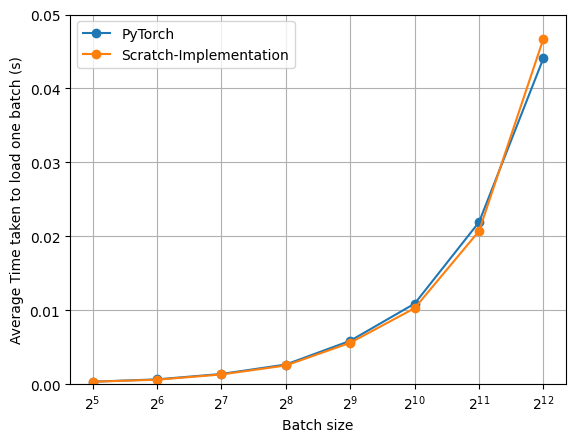

In [7]:
plt.plot([2**i for i in range(5, 13)], times[0], label="PyTorch", marker="o")
plt.plot([2**i for i in range(5, 13)], times[1], label="Scratch-Implementation", marker="o")

plt.xlabel("Batch size")
plt.ylabel("Average Time taken to load one batch (s)")
plt.legend()

plt.xscale("log", base=2)
plt.ylim(0, 0.05)
plt.grid(True)
plt.show()

## **Question: 2**

In this question, we implement a simple Feed-Forward Neural Netowrk using Pytorch with the following specifications:
- 4 Hidden Layers
- At least 32 Nodes in each Hidden Layer
- Load the data using the more effective dataloader as identified in Question-1
- Activation Function: [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Loss Function: [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- Optimizer: [`torch.optim.SGD` (Stochastic Gradient Descent)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
- Learning Rate: 0.0003

Finally, we plot graphs of the loss and accuracy vs number of epochs for training, testing, and validation data for 60 epochs.

### **References**

1. [PyTorch Crash Course - Getting Started with Deep Learning, YouTube](https://www.youtube.com/watch?v=OIenNRt2bjg)
2. [PyTorch Official Documentation](https://pytorch.org/docs/stable/index.html)

### **Observations**

1. Even with 4 hidden layers of 128 neurons each, the model achieves a menial accuracy of 12%.
2. The learning rate 0.0003 seems to be too small for the model, and the model often gets stuck in some local minima - achieving no improvement in loss or accuracy via updates.
3. With a higher learning rate of 0.003, the loss of the model decreases significantly, but the accuracy remains in the same range. This is probably due to overfitting - we can reduce the number of hidden layers and number of epochs for a better generalization.

In [8]:
class NeuralNetwork(nn.Module):
    ACCURACIES: np.ndarray
    LOSSES: np.ndarray

    def __init__(self, input_size: int, hidden_size: list[int], output_size: int):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size[0]))
        layers.append(nn.ReLU())
        # layers.append(nn.BatchNorm1d(hidden_size[0], affine=False))
        for i in range(len(hidden_size)-1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            layers.append(nn.ReLU())
            # layers.append(nn.BatchNorm1d(hidden_size[i+1], affine=False))
        layers.append(nn.Linear(hidden_size[-1], output_size))

        self.LOSSES = np.zeros((3, 1))
        self.ACCURACIES = np.zeros((3, 1))
        self.layers = nn.Sequential(*layers)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

    def train(self, dataloader: list[CustomDataLoader|DataLoader], epochs: int, lr: float, verbose: bool|None = False) -> None:
        self.ACCURACIES.resize((3, epochs))
        self.LOSSES.resize((3, epochs))

        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        for epoch in range(epochs):
            for batch, (images, labels) in enumerate(dataloader[0], start=1):
                outputs = self.forward(images.reshape(-1, 28*28))
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            with torch.no_grad():
                for index, loader in enumerate(dataloader):
                    self.evaluate(loader, index, epoch)

            if verbose:
                epoch_ = f"Epoch [{str(epoch+1).zfill(2)}/{epochs}]"
                accuracy_, loss_ = self.ACCURACIES[0, epoch], self.LOSSES[0, epoch]
                print(f"{epoch_}, (Training) Accuracy: {accuracy_:.10f}, (Training) Loss: {loss_:.10f}", end="\r")

    def evaluate(self, dataloader: CustomDataLoader|DataLoader, index: int, epoch: int) -> None:
        loss = correct = total = 0
        for images, labels in dataloader:
            total += labels.shape[0]
            outputs = self.forward(images.reshape(-1, 28*28))
            loss += self.criterion(outputs, labels).item()
            correct += (outputs.argmax(axis=1) == labels).sum().item()

        self.ACCURACIES[index, epoch] = correct / total
        self.LOSSES[index, epoch] = loss / total

In [9]:
train_data = MNISTDataset(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = MNISTDataset(root="data", train=False, download=True, transform=transforms.ToTensor())

size = int(0.8 * len(train_data))
train_data, val_data = random_split(train_data, [size, len(train_data) - size])

batch_size = 128
train_loader = CustomDataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = CustomDataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = CustomDataLoader(val_data, batch_size=batch_size, shuffle=False)

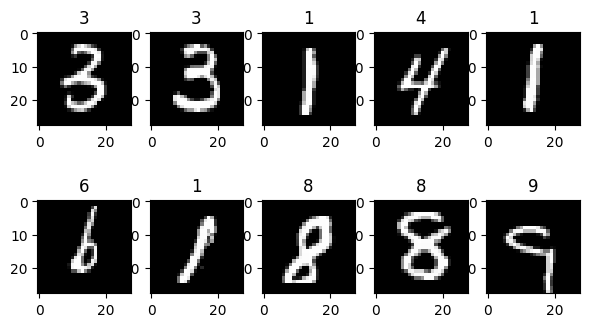

In [10]:
# SANITY CHECK
examples = iter(train_loader)
example_data, example_targets = next(examples)

plt.figure(figsize=(7, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(example_targets[i].item())
plt.show()

In [11]:
input_size = 28 * 28
hidden_size = [50, 40, 36, 36]
output_size = 10
epochs = 60
lr = 3e-4

model = NeuralNetwork(input_size, hidden_size, output_size)
model.train([train_loader, test_loader, val_loader], epochs, lr, verbose=True)
# torch.save(model.state_dict(), "model.pt")

KeyboardInterrupt: 

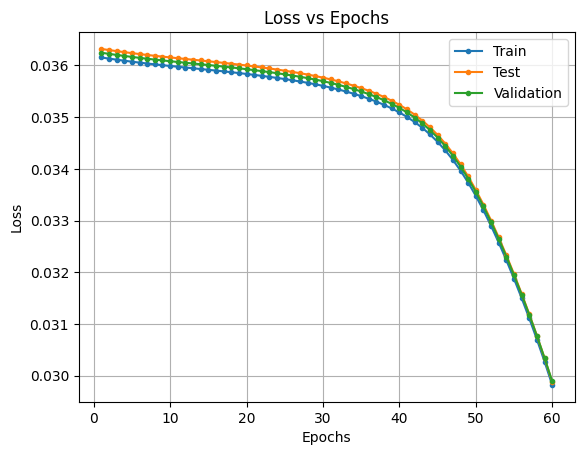

In [88]:
plt.plot(range(1, epochs+1), model.LOSSES[0], label="Train", marker=".")
plt.plot(range(1, epochs+1), model.LOSSES[1], label="Test", marker=".")
plt.plot(range(1, epochs+1), model.LOSSES[2], label="Validation", marker=".")

plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

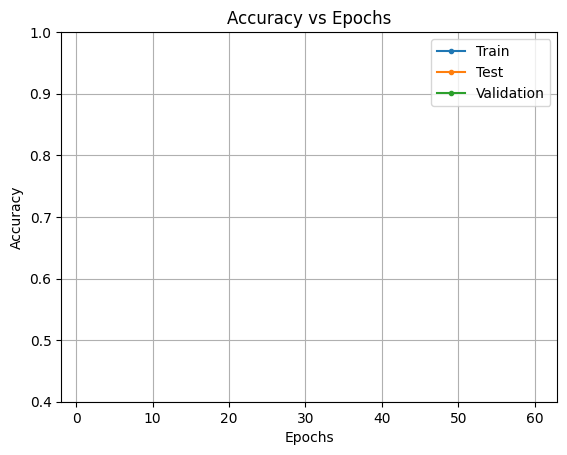

In [89]:
plt.plot(range(1, epochs+1), model.ACCURACIES[0], label="Train", marker=".")
plt.plot(range(1, epochs+1), model.ACCURACIES[1], label="Test", marker=".")
plt.plot(range(1, epochs+1), model.ACCURACIES[2], label="Validation", marker=".")

plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.ylim(0.4, 1)
plt.yticks(np.arange(0.4, 1.1, 0.1))
plt.legend()
plt.grid(True)
plt.show()

## **Question: 3**

In this question, we are required to write the FeedForward network from scratch using only PyTorch Tensor operations, while manually implementing the trianing loop and gradient calculations. The same hyperparameters as in Question-2 are used. The model is trained for 60 epochs, and the loss and accuracy vs number of epochs for training, testing, and validation data are plotted.

In [299]:
class Layer:
    """
    Abstract class to represent a Layer of a Neural Network
    """

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def update(self, lr: float) -> None:
        raise NotImplementedError


class Linear(Layer):
    def __init__(self, input_size: int, output_size: int):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = torch.rand(input_size, output_size) * np.sqrt(2 / input_size)
        self.bias = torch.rand(output_size) * np.sqrt(2 / input_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.x = x
            return self.x @ self.weights + self.bias

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.weights_grad = self.x.T @ grad
            self.bias_grad = grad.sum(axis=0)
            return grad @ self.weights.T

    def update(self, lr: float) -> None:
        with torch.no_grad():
            self.weights -= lr * self.weights_grad
            self.bias -= lr * self.bias_grad


class ReLU(Layer):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.x = x
            return torch.max(x, torch.zeros_like(x))

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return grad * (self.x > 0).float()

    def update(self, lr: float) -> None:
        pass


class BatchNorm(Layer):
    def __init__(self, input_size: int):
        self.input_size = input_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.x = x
            self.mean = x.mean(axis=0)
            self.std = x.std(axis=0) + 1e-12
            return (self.x - self.mean) / self.std

    def backward(self, grad: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return grad / self.std

    def update(self, lr: float) -> None:
        pass


class CrossEntropyLoss:
    def __call__(self, outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.outputs = outputs.softmax(axis=1)
            self.targets = targets
            return -torch.log(outputs[range(len(targets)), targets]).mean()

    def backward(self) -> torch.Tensor:
        with torch.no_grad():
            return (self.outputs - torch.eye(self.outputs.shape[1])[self.targets]) / len(self.targets)


class SGD:
    def __init__(self, parameters: list[Layer], lr: float):
        self.parameters = parameters[::-1]
        self.lr = lr

    def step(self, grad: torch.Tensor) -> None:
        with torch.no_grad():
            for parameter in self.parameters:
                grad = parameter.backward(grad)
                parameter.update(self.lr)


class CustomNeuralNetwork:
    ACCURACIES: np.ndarray
    LOSSES: np.ndarray

    def __init__(self, input_size: int, hidden_size: list[int], output_size: int):
        self.layers = []
        self.layers.append(Linear(input_size, hidden_size[0]))
        self.layers.append(ReLU())
        # self.layers.append(BatchNorm(hidden_size[0]))
        for i in range(len(hidden_size)-1):
            self.layers.append(Linear(hidden_size[i], hidden_size[i+1]))
            self.layers.append(ReLU())
            # self.layers.append(BatchNorm(hidden_size[i+1]))
        self.layers.append(Linear(hidden_size[-1], output_size))

        self.LOSSES = np.zeros((3, 1))
        self.ACCURACIES = np.zeros((3, 1))
        self.criterion = CrossEntropyLoss()

    def parameters(self) -> list[Layer]:
        return self.layers

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, layer in enumerate(self.layers):
            x = layer.forward(x)
        return x

    def train(self, dataloader: list[CustomDataLoader|DataLoader], epochs: int, lr: float, verbose: bool|None = False) -> None:
        self.ACCURACIES.resize((3, epochs))
        self.LOSSES.resize((3, epochs))

        optimizer = SGD(model.parameters(), lr=lr)
        for epoch in range(epochs):
            for batch, (images, labels) in enumerate(dataloader[0], start=1):
                outputs = self.forward(images.reshape(-1, 28*28))
                loss = self.criterion(outputs, labels)
                optimizer.step(self.criterion.backward())

            with torch.no_grad():
                for index, loader in enumerate(dataloader):
                    self.evaluate(loader, index, epoch)

            if verbose:
                epoch_ = f"Epoch [{str(epoch+1).zfill(2)}/{epochs}]"
                accuracy_, loss_ = self.ACCURACIES[0, epoch], self.LOSSES[0, epoch]
                print(f"{epoch_}, (Training) Accuracy: {accuracy_:.10f}, (Training) Loss: {loss_:.10f}", end="\r")

    def evaluate(self, dataloader: CustomDataLoader|DataLoader, index: int, epoch: int) -> None:
        loss = correct = total = 0
        for images, labels in dataloader:
            total += labels.shape[0]
            outputs = self.forward(images.reshape(-1, 28*28))
            loss += self.criterion(outputs, labels).item()
            correct += (outputs.argmax(axis=1) == labels).sum().item()

        self.ACCURACIES[index, epoch] = correct / total
        self.LOSSES[index, epoch] = loss / total

In [301]:
input_size = 28 * 28
hidden_size = [50, 40, 36, 36]
output_size = 10
epochs = 60
lr = 3e-4

model = CustomNeuralNetwork(input_size, hidden_size, output_size)
model.train([train_loader, test_loader, val_loader], epochs, lr, verbose=True)
# torch.save(model.state_dict(), "model.pt")

KeyboardInterrupt: 

## **Question: 4**

In this question, we repreat both Question 2 and 3, but just using Sigmoid activation function instead of ReLU. The same hyperparameters as in Question-2 are used. The model is trained for 60 epochs, and the loss and accuracy vs number of epochs for training, testing, and validation data are plotted.

### **PyTorch Model**